#### Loading and preparing the PCam data for training deep learning models using tensorflow dataset (tfds)

Loading the required libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [2]:
# Check if TensorFlow was built with CUDA (GPU support)
print("Built with GPU support:", tf.test.is_built_with_cuda())

# Check for available GPUs and list them
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:", [gpu.name for gpu in gpus])
else:
    print("No GPUs available.")

Built with GPU support: True
GPUs available: ['/physical_device:GPU:0']


In [3]:
# Check if TensorFlow can see the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


Defining a function that splits images and labels and one-hot-encodes the labels

In [4]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

Next we use the tensorflow dataset API - tfds - to load the data from you local directory. First you have to download the data manually from https://syddanskuni-my.sharepoint.com/:f:/g/personal/cmd_sam_sdu_dk/EiWD2LmuxCJBp-_tfGK7aL8Bdt2cPsb6MCpVs1pOYUcXAw?email=cmd%40sam.sdu.dk&e=2Vx6tL and store it on you local drive. First some important remarks:
- The folder structure is **crucial** and needs to be copied to your local drive. For example, if you with to use the folder denoted *c:\user\aml_take_home_exam* then you need to download the data to *c:\user\aml_take_home_exam\patch_camelyon\2.0.0*.
- As you can see from the example below this implies that my data is stored locally under *V:\BDADShareData2\DATA_TFDS_BDAD\patch_camelyon\2.0.0*
- By using tfds.load you do not need to load all data. If you only want 20% of the training data and 5% of test and validation data you simply specify **split=['train[:20%]','test[:5%]','validation[:5%]']**. In this case the variable ds1 contains only 20 percent of the training data while ds2 and ds3 contains 5% of the test and validation data respectively. This feature is important if you are facing hardware contraints.
- You can read more about tensorflow dataset here https://www.tensorflow.org/datasets 
- **Note** If you wish not to use data stored locally you can use download=True and tensorflow will download the data for you. 

In [5]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = 'D:\data',
                        download=False,
                        shuffle_files=True)

Next we simple transform the data (by the function convert sample described previously) and getting ready for training by splitting it into batches.

In [6]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

The data is then ready to be applied for training, validation, testing etc...below just a very very simple illustration on how to construct and train a model based on the data we have prepared

In [7]:
def first_ccn_model():
    input_img = Input(shape=(96,96,3))
    
    x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
    x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    y = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=y)
    return model

sgd_opt = SGD(learning_rate=0.01, momentum=0.9, decay=0.0, nesterov=True)

model = first_ccn_model()

model.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_dataset,
                 validation_data=validation_dataset,
                 epochs=2)

Epoch 1/2
1639/1639 [==============================] - 32s 18ms/step - loss: 0.6379 - accuracy: 0.6213 - val_loss: 0.7837 - val_accuracy: 0.6020
Epoch 2/2
1639/1639 [==============================] - 24s 14ms/step - loss: 0.5156 - accuracy: 0.7416 - val_loss: 0.5122 - val_accuracy: 0.7680


In [22]:
print(f'length of training dataset: {len(train_dataset)}, length of validation dataset: {len(validation_dataset)} and length of test dataset: {len(test_dataset)}')

length of training dataset: 1639, length of validation dataset: 52 and length of test dataset: 52


In [16]:
for images, labels in train_dataset.take(1):
    batch_size = images.shape[0]  
    print("Batch size:", batch_size)
    print("Images shape:", images.shape)  
    print("Labels shape:", labels.shape)  


Batch size: 32
Images shape: (32, 96, 96, 3)
Labels shape: (32, 2)


Original shape: (96, 96, 3)
Shape after tf.squeeze: (96, 96, 3)
Original shape: (96, 96, 3)
Shape after tf.squeeze: (96, 96, 3)
Original shape: (96, 96, 3)
Shape after tf.squeeze: (96, 96, 3)
Original shape: (96, 96, 3)
Shape after tf.squeeze: (96, 96, 3)
Original shape: (96, 96, 3)
Shape after tf.squeeze: (96, 96, 3)
Original shape: (96, 96, 3)
Shape after tf.squeeze: (96, 96, 3)
Original shape: (96, 96, 3)
Shape after tf.squeeze: (96, 96, 3)
Original shape: (96, 96, 3)
Shape after tf.squeeze: (96, 96, 3)
Original shape: (96, 96, 3)
Shape after tf.squeeze: (96, 96, 3)
Original shape: (96, 96, 3)
Shape after tf.squeeze: (96, 96, 3)


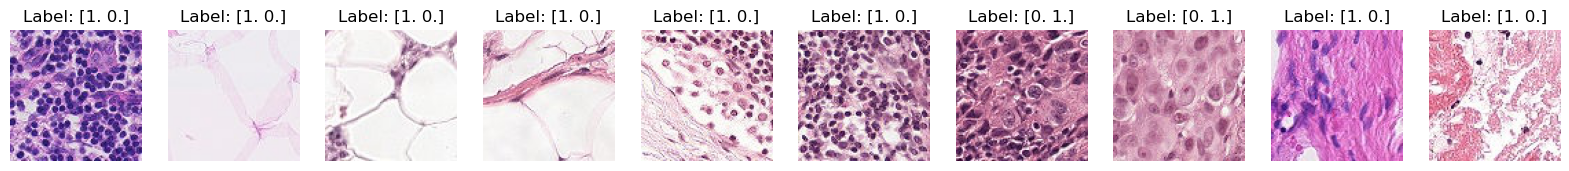

In [15]:
n = 10  
plt.figure(figsize=(20, 4)) 

for image_batch, label_batch in train_dataset.take(1):
    for i in range(n):
        if i < len(image_batch): 
            ax = plt.subplot(1, n, i + 1)
           
            image = image_batch[i]
            label = label_batch[i]
            print("Original shape:", image.shape)  
            squeezed_image = tf.squeeze(image)  
            print("Shape after tf.squeeze:", squeezed_image.shape)  

            ax.imshow(squeezed_image)  
            ax.set_title(f'Label: {label.numpy()}')
            ax.axis('off')

plt.show()